In [1]:
import yaml
import pathlib
import os

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from sklearn.calibration import calibration_curve
import relplot as rp

import uq_methods as uqm
from joblib import Parallel, delayed
import pandas as pd
import rasterio as rio
from rasterio import features
import seaborn as sns

import matplotlib as mpl
import vectorize as vec
from shapely import LineString, MultiLineString, get_point, get_num_points
from shapely.ops import linemerge
from skimage import feature, filters

from skimage.feature import canny

In [3]:
cwd = pathlib.Path(os.getcwd())
with open(cwd.parent / 'config.yaml') as stream:
    config = yaml.safe_load(stream)

config['Directories']['work_dir'] = pathlib.Path(config['Directories']['work_dir'])

for key, value in config['Directories'].items():
    if key == 'work_dir' or key == 'color_to_phase_dicts':
        continue
    else:
        config['Directories'][key] = config['Directories']['work_dir'] / value
ml_dataset = gpd.read_file(config['Directories']['geom_dir'])
ml_dataset = ml_dataset.loc[ml_dataset.dataset != 'test_interferometric_only', :]

In [3]:
with open(config['Directories']['split']) as split_info:
    split = split_info.readlines()
    split = [elem.strip() for elem in split]

test_samples = split[split.index('test_valids') + 1:split.index('test_empties')]
# test_samples = [config['Directories']['save_predictions_npz'] / config['Model_Details']['save_predictions'] / 'epoch=74-val_loss' / sample for sample in test_samples]

In [ ]:
test_gls = ml_dataset.loc[ml_dataset.dataset == 'test']
predictions, ground_truths = uqm.get_pixels_in_buffer(samples = test_samples, ground_truth_tif_dir = config['Directories']['labels_tif'], 
                                                 gls = test_gls, buffer = 200)
predictions_full, ground_truths_full = uqm.get_predictions_and_label_pixels(samples = test_samples, ground_truth_tif_dir = config['Directories']['labels_tif'])

In [ ]:
fig1, ax1 = rp.rel_diagram_binned(predictions, ground_truths)
fig2, ax2 = rp.rel_diagram(predictions, ground_truths)

In [ ]:
uqm.plot_reliability_diagram(predictions, ground_truths, class_balanced = False, confidence_measure = 'default')

In [ ]:
fig, ax = rp.rel_diagram_binned(predictions_full, ground_truths_full)

In [ ]:
uqm.plot_reliability_diagram(predictions_full, ground_truths_full, class_balanced = False)

In [ ]:
with np.load(test_samples[7]) as data:
    prediction = data['arr_0'][:, :, 0]

fig = plt.figure(figsize = (10, 10), tight_layout = 'True')
ax1 = fig.add_subplot(1, 2, 1)
full = ax1.imshow(prediction, cmap = 'plasma', interpolation = 'bilinear')
fig.colorbar(full, ax = ax1, fraction = 0.046, pad = 0.046)

confidence = uqm.shannon_confidence(prediction)
ax2 = fig.add_subplot(1, 2, 2)
conf = ax2.imshow(confidence, aspect = "auto", vmin = 0, vmax = 1)
conf_band = np.zeros((*confidence.shape, 4))
conf_band[:, :, 0] = 1
conf_band[:, :, 3] = (conf < 0.95) * 0.5
ax2.imshow(conf_band, aspect = "auto", vmin = 0, vmax = 1)

Errors vs. Std. - ensemble

In [4]:
expts = ['HED_256_100_wce_rectangular/epoch=73-val_loss',
        'HED_256_100_wce_rectangular_seed_290/epoch=15-val_loss',
        'HED_256_100_wce_rectangular_seed_3275/epoch=58-val_loss',
        'HED_256_100_wce_rectangular_seed_5/epoch=79-val_loss',
        'HED_256_100_wce_rectangular_seed_56/epoch=54-val_loss']

expts_path = [config['Directories']['output_vectors'] / expt for expt in expts]

shps = Parallel(n_jobs = -1)(delayed(gpd.read_file)(list(expt.glob('epoch*.geojson'))[0]) for expt in expts_path)
polis_distances = [pd.DataFrame(np.load(list(expt.glob('polis_distances.npy'))[0], allow_pickle = True).item()) for expt in expts_path]
expt_metrics = [np.load(expt / 'metrics.npy', allow_pickle = True) for expt in expts_path]

In [ ]:
expt_metrics

In [102]:
test_samples = ml_dataset.loc[ml_dataset.dataset == 'test', :]
sample = test_samples.sample(1)
print(sample.UUID.values[0])

SEN_HH_054_D_R_01_20171216102441_20171222102359_20171228102441________________000388


In [28]:
def raster_to_vector_refined(ref_tif, prediction, threshold = 0.8):
    with rio.open(ref_tif) as tif:
            transform = tif.transform
    if threshold:
        encoded = vec.threshold_predictions(prediction, threshold) 
    else:
        encoded = prediction
    skeleton = vec.prune_skeleton(vec.skeletonize(encoded).astype('uint8'))
    pruned, _, segment_objects = vec.pcv.morphology.prune(skel_img = skeleton, size = 0)
    filled = vec.pcv.morphology.fill_segments(mask = pruned, objects = list(segment_objects))
    segments = vec.get_segments(filled_mask = filled)
    segment_ends = vec.find_segment_ends(segments = segments, skeleton = pruned)
    vectors = vec.raster_to_lines(segments = segments, segment_ends = segment_ends, transform = transform)
    vectors = vec.unary_union(vec.smoothen_line(vector = vectors, sigma = 10))
    return vectors

In [29]:
def raster_to_vector(ref_tif, prediction, threshold = 0.8):
    with rio.open(ref_tif) as tif:
            transform = tif.transform
    encoded = vec.threshold_predictions(prediction, threshold)
    
    shapes = [{'properties': {'cluster_id': int(v)}, 'geometry': s} for (s, v) in (features.shapes(encoded, mask = encoded.astype(bool), transform = transform, connectivity = 8))]
    
    lines = [LineString(shape['geometry']['coordinates'][0]) for shape in shapes]
    
    vector = linemerge(MultiLineString(lines))
    return vector

In [30]:
savedir = config['Directories']['save_predictions_npz'] / 'HED_256_100_wce_rectangular_ensemble_results'

In [69]:
threshold = 0.8

for tile in config['Directories']['labels_npz'].glob(sample.UUID.values[0] + '*.npz'):
    with np.load(tile) as data:
        if np.any(data['arr_0']):
            ensemble_predictions = [config['Directories']['save_predictions_npz'] / expt / tile.name for expt in expts]
            ensemble_mean, ensemble_std = uqm.get_average_std_predictions(predictions = ensemble_predictions, savedir = savedir)
            np.savez_compressed(savedir / (tile.name.removesuffix('.npz') + '_mean.npz'), ensemble_mean[:, :, np.newaxis])
            np.savez_compressed(savedir / (tile.name.removesuffix('.npz') + '_std.npz'), ensemble_std[:, :, np.newaxis])
            ensemble_mean_minus_std = np.abs(ensemble_mean - ensemble_std)
            ensemble_mean_plus_std = ensemble_mean + ensemble_std
            min_val = np.min(ensemble_mean_plus_std)
            ensemble_mean_plus_std = (ensemble_mean_plus_std - min_val) / (np.max(ensemble_mean_plus_std) - min_val)

In [70]:
for expt in expts:
    vec.merge_npz(npz_dir = config['Directories']['save_predictions_npz'] / expt, tif_dir = config['Directories']['labels_tif'], ref_tif = config['Directories']['labels_reference'] / (sample.UUID.values[0] + '.tif'), 
              savedir = config['Directories']['save_predictions_npz'] / expt)
vec.merge_npz(npz_dir = savedir, tif_dir = config['Directories']['labels_tif'], ref_tif = config['Directories']['labels_reference'] / (sample.UUID.values[0] + '.tif'), 
              savedir = savedir, glob_for = '*_mean.npz')
vec.merge_npz(npz_dir = savedir, tif_dir = config['Directories']['labels_tif'], ref_tif = config['Directories']['labels_reference'] / (sample.UUID.values[0] + '.tif'), 
              savedir = savedir, glob_for = '*_std.npz')

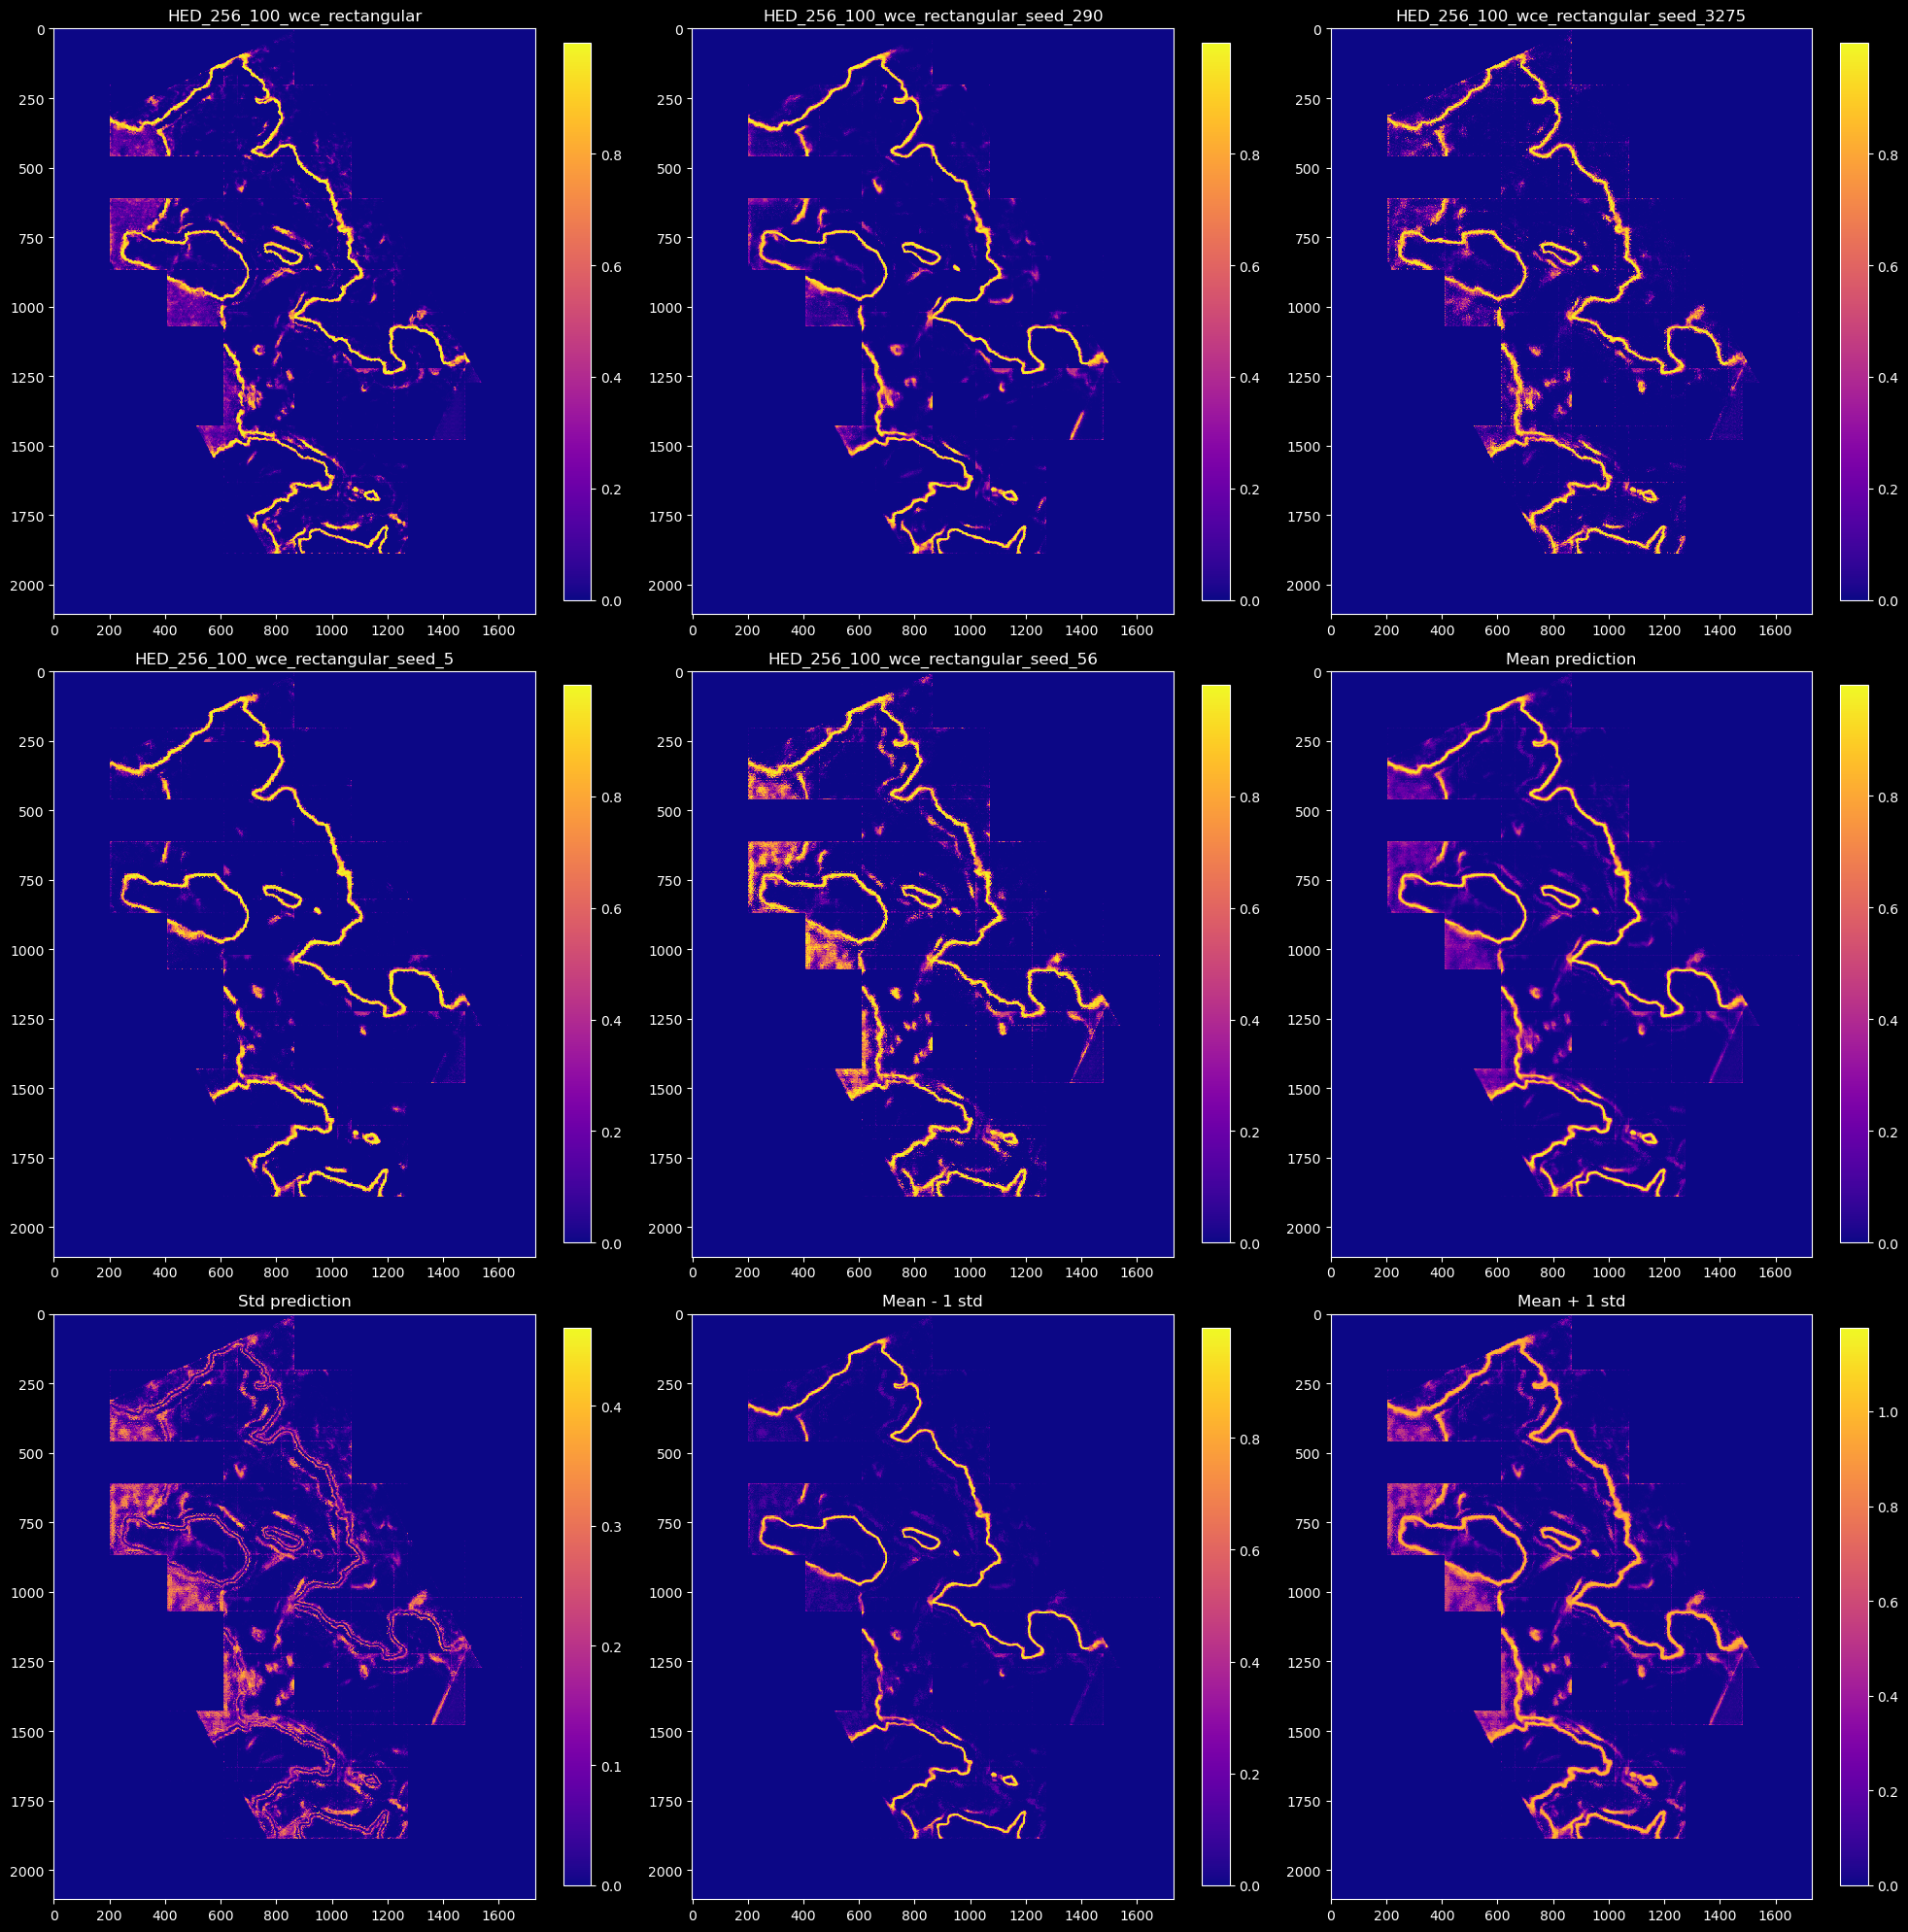

In [103]:
fig = plt.figure(figsize = (20, 20), tight_layout = True)

for index, expt in enumerate(expts):
    with np.load(config['Directories']['save_predictions_npz'] / expt / (sample.UUID.values[0] + '.npz')) as data:
        ax = fig.add_subplot(3, 3, index + 1)
        ax.set_title(expt[:expt.find('/')])
        pred = ax.imshow(data['arr_0'][:, :, 0], cmap = 'plasma', interpolation = 'None')
        fig.colorbar(pred, ax = ax, fraction = 0.046, pad = 0.046)

with np.load(savedir / (sample.UUID.values[0] + '_mean.npz')) as data:
    ensemble_mean = data['arr_0'][:, :, 0]

with np.load(savedir / (sample.UUID.values[0] + '_std.npz')) as data:
    ensemble_std = data['arr_0'][:, :, 0]

ax6 = fig.add_subplot(3, 3, 6)
ax6.set_title('Mean prediction')
mean = ax6.imshow(ensemble_mean, cmap = 'plasma', interpolation = 'None')
fig.colorbar(mean, ax = ax6, pad = 0.046, fraction = 0.046)

ax7 = fig.add_subplot(3, 3, 7)
ax7.set_title('Std prediction')
std = ax7.imshow(ensemble_std, cmap = 'plasma', interpolation = 'None')
fig.colorbar(std, ax = ax7, pad = 0.046, fraction = 0.046)

ensemble_mean_minus_std = np.abs(ensemble_mean - ensemble_std)
ensemble_mean_plus_std = ensemble_mean + ensemble_std
# min_val = np.min(ensemble_mean_plus_std)
# ensemble_mean_plus_std = (ensemble_mean_plus_std - min_val) / (np.max(ensemble_mean_plus_std) - min_val)

ax8 = fig.add_subplot(3, 3, 8)
ax8.set_title('Mean - 1 std')
std1 = ax8.imshow(ensemble_mean_minus_std, cmap = 'plasma', interpolation = 'None')
fig.colorbar(std1, ax = ax8, pad = 0.046, fraction = 0.046)

ax9 = fig.add_subplot(3, 3, 9)
ax9.set_title('Mean + 1 std')
std2 = ax9.imshow(ensemble_mean_plus_std, cmap = 'plasma', interpolation = 'None')
fig.colorbar(std2, ax = ax9, pad = 0.046, fraction = 0.046)

In [104]:
mean_vector = []
mean_plus_std_vector = []

for tile in savedir.glob(sample.UUID.values[0] + '_tile*_mean.npz'):
    with np.load(tile) as data:
        mean = data['arr_0'][:, :, 0]
    
    with np.load(tile.parent / (tile.name.removesuffix('mean.npz') + 'std.npz')) as data: 
        std = data['arr_0'][:, :, 0]
    
    ref_tif = config['Directories']['labels_tif'] / (tile.name.removesuffix('_mean.npz') + '.tif')
    mean_vector.append(raster_to_vector_refined(ref_tif = ref_tif, prediction = mean, threshold = 0.5))

    ensemble_mean_plus_std = mean + (2 * std)
    ensemble_mean_plus_std = np.where(mean >= 0.5, ensemble_mean_plus_std, 0.0)
    error_bounds = canny(ensemble_mean_plus_std, sigma = 10).astype(np.uint8)
    mean_plus_std_vector.append(raster_to_vector_refined(ref_tif = ref_tif, prediction = error_bounds, threshold = None))

mean_vector = gpd.GeoDataFrame(geometry = mean_vector, crs = 'EPSG:3031')
mean_plus_std_vector = gpd.GeoDataFrame(geometry = mean_plus_std_vector, crs = 'EPSG:3031')

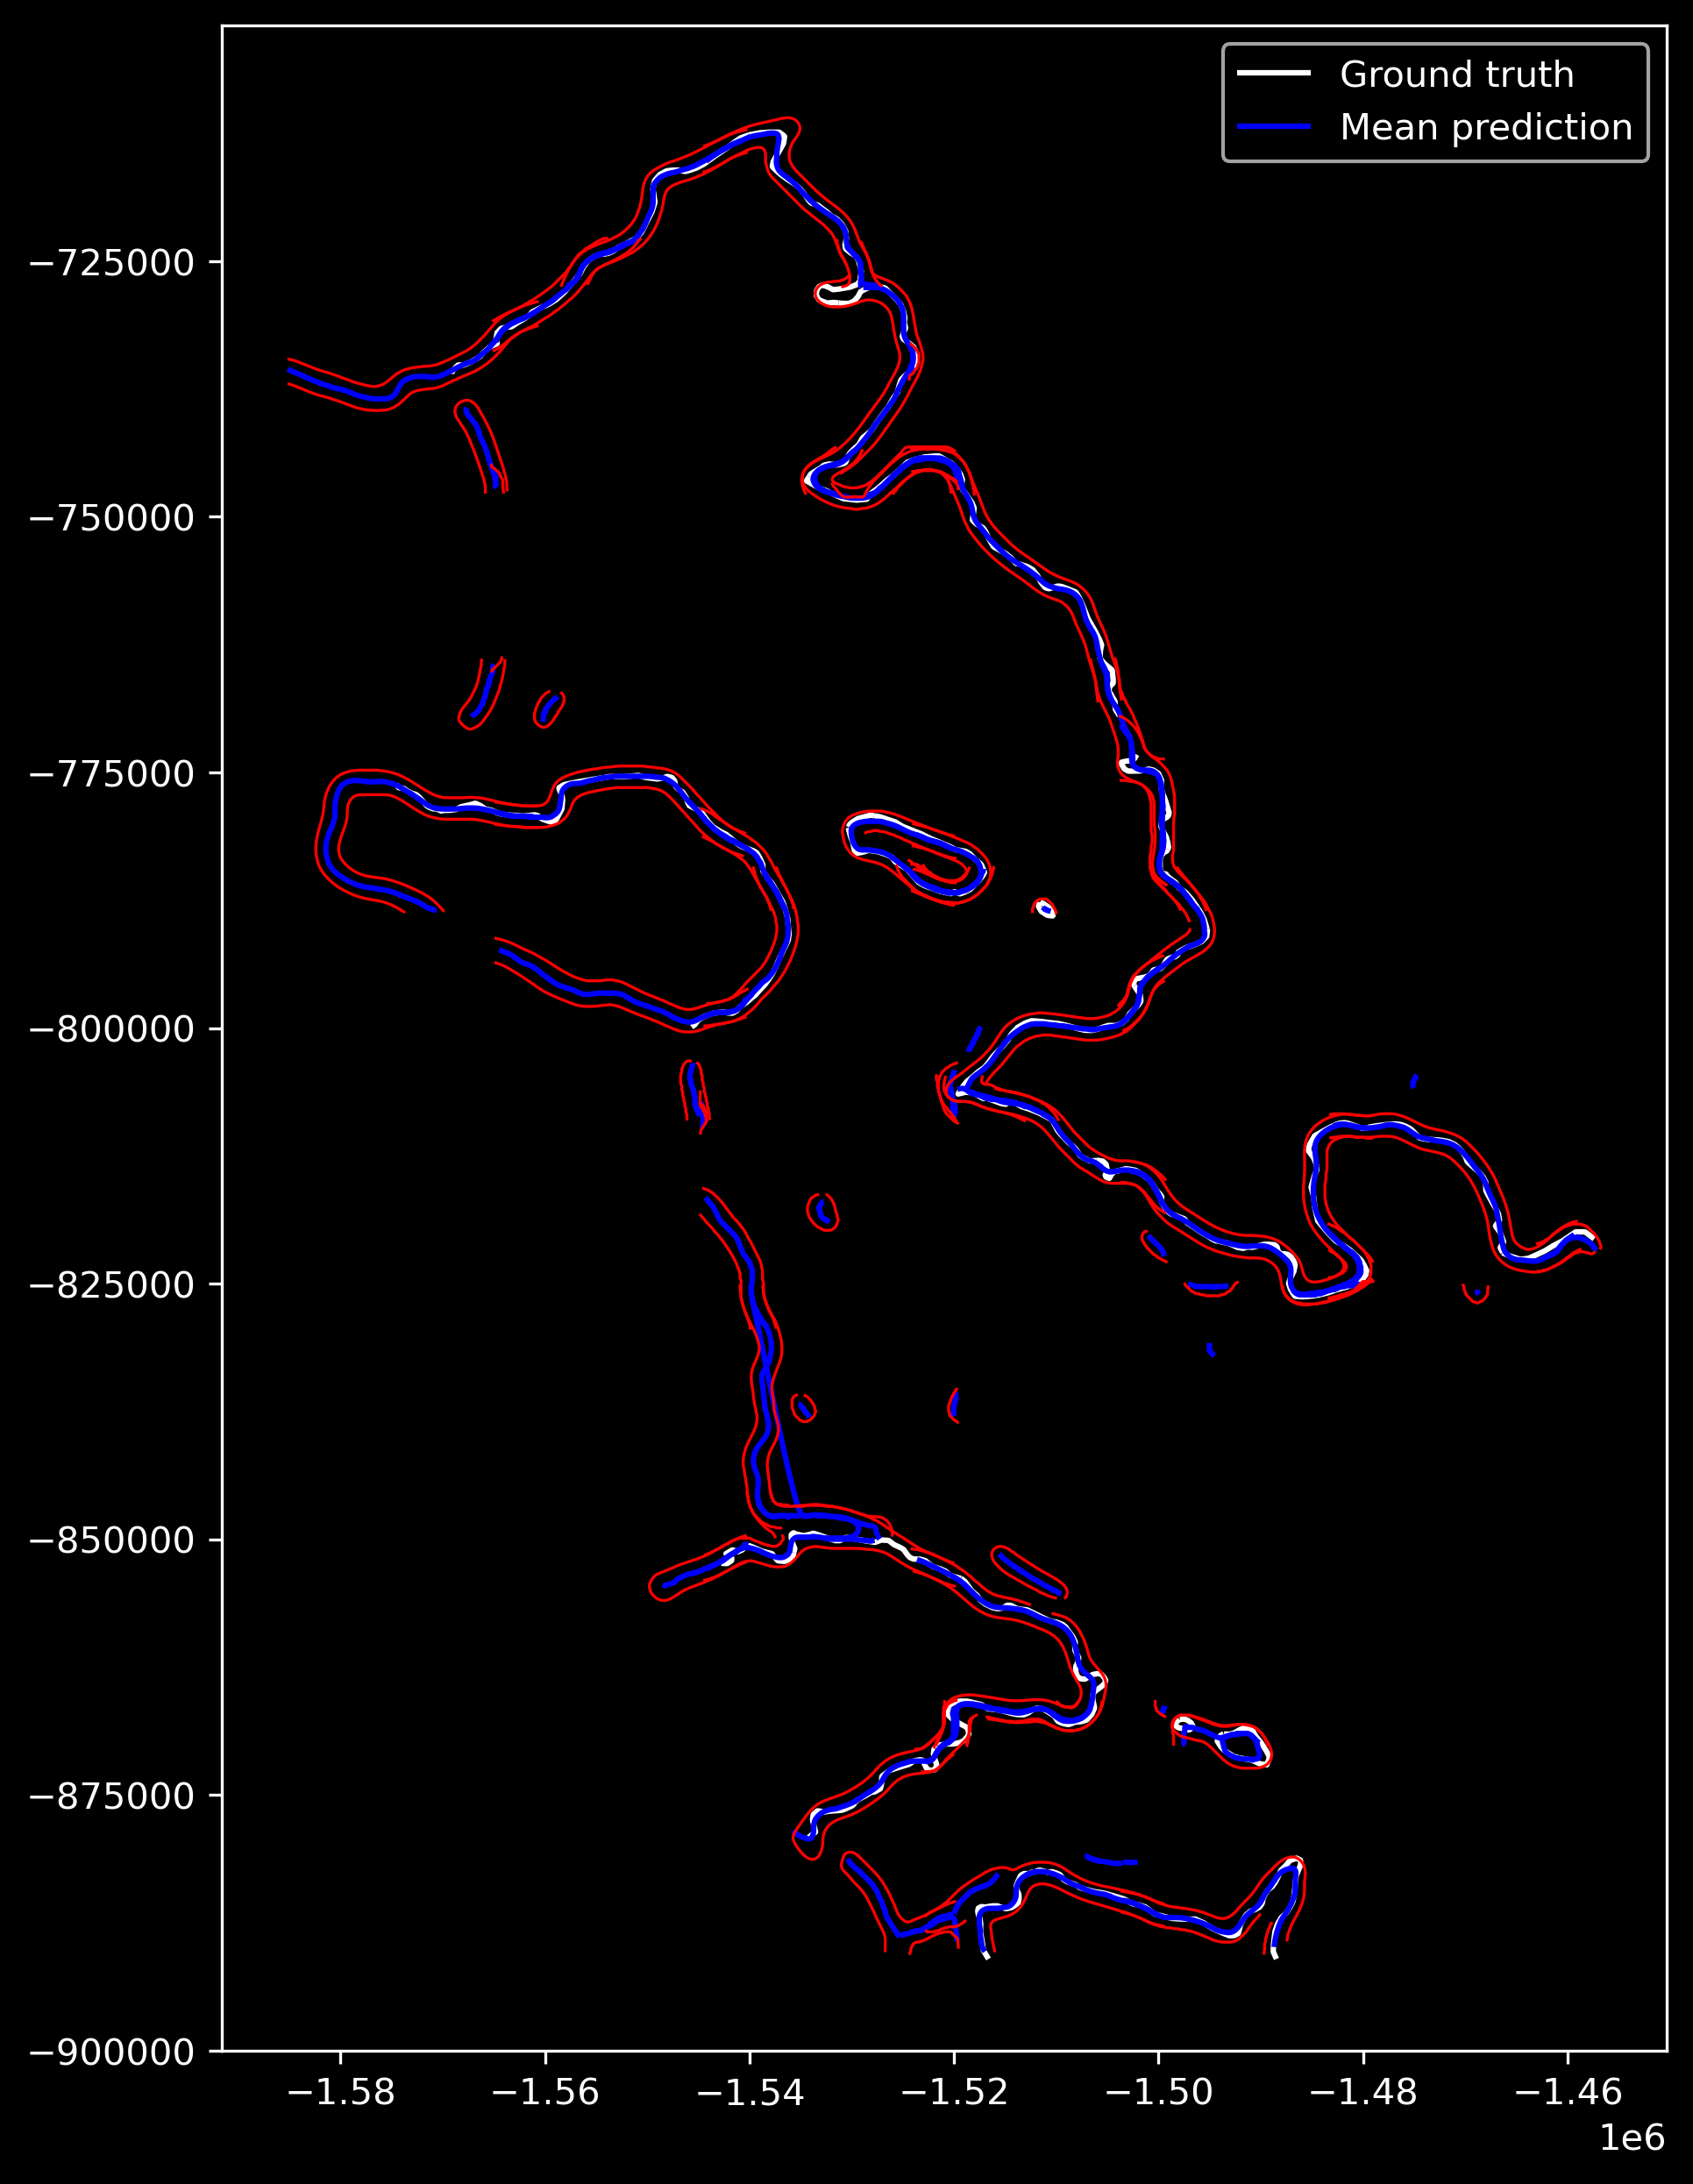

In [105]:
fig = plt.figure(figsize = (10, 10), dpi = 300)
ax = fig.add_subplot(1, 1, 1)
sample.plot(ax = ax, color = 'white', label = 'Ground truth', legend = True)
mean_vector.plot(ax = ax, color = 'blue', label = 'Mean prediction', legend = True)
mean_plus_std_vector.plot(ax = ax, color = 'red', linewidth = 0.8)
ax.legend()

In [ ]:
vec.

In [ ]:
# vector_means = gpd.GeoDataFrame(data = {'UUID': ml_dataset.UUID.values, 'dataset': ml_dataset.dataset.values})
# std_bounds = gpd.GeoDataFrame(data = {'UUID': ml_dataset.UUID.values, 'dataset': ml_dataset.dataset.values})

In [ ]:
def get_mean_geometry(ensemble_lines):
    exploded_lines = [line.explode(index_parts = True) for line in ensemble_lines]
    exploded_lines
    # for line in lines:
    #     for substring in get_parts(line):
    #         line_lengths = []
    #         line_lengths.append(get_num_coordinates(substring))
        
    #     coords = np.zeros((np.max(line_lengths), 2, len(lines)), dtype = np.float32)
    #     for index, line in enumerate(lines):
    #         coords[:line_lengths[index], :, index] = get_coordinates(line)
    
    # mean_coords = np.mean(coords, axis = -1)
    # # std_coords = np.std(coords, axis = -1)
    # # mean_plus_std_line = LineString(mean_coords + std_coords)
    # # mean_minus_std_line = LineString(mean_coords - std_coords)
    # mean_line = LineString(mean_coords)
    # # std_bounds_line = MultiLineString([mean_minus_std_line, mean_plus_std_line])
    # return mean_line

In [ ]:
with rio.open(config['Directories']['downsampled_dinsar'] / (sample.UUID.values[0] + '.tif')) as tif:
    phase = tif.read(4)
    bounds = tif.bounds

fig = plt.figure(figsize = (10, 10), tight_layout = True, dpi = 200)
ax1 = fig.add_subplot(1, 1, 1)
ph = ax1.imshow(phase, cmap = 'hsv', extent = [bounds.left, bounds.right, bounds.bottom, bounds.top], interpolation = 'None', alpha = 0.5)
fig.colorbar(ph, ax = ax1, fraction = 0.046, pad = 0.046, label = 'radians')
sample.plot(ax = ax1, color = 'white', label = 'AIS_cci', legend = True)
# ensemble_means.plot(ax = ax1, color = 'blue', label = 'Mean line', legend = True)
# ensemble_std_bounds.plot(ax = ax1, color = 'red', label = '+- std lines', legend = True)
# ax1.legend()
# cmap = mpl.colormaps['rainbow']
# colors = cmap(np.linspace(0, 1, len(expts)))

# predictions = [shp.loc[shp.UUID == sample.UUID.values[0]] for shp in shps]
# for prediction, expt, color in zip(predictions, expts, colors):
#     prediction.plot(ax = ax1, color = color, label = expt[:expt.find('/')], legend = True)
